# CS377 Reinforcement Learning HW3

**How to submit**
*   Fill out 🛑 <mark> TODO</mark> blocks, **DO NOT** modify other parts of the skeleton code.
*   Submit one file: {student_ID}.ipynb to KLMS

    e.g. 20251234.ipynb
* **Before submission, do not forget to click Runtime -> Restart and run all**


**Important Notice**
*   From this assignment, you will use PyTorch.
*   If you are unfamiliar with PyTorch, please check the PyTorch [tutorial](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html) and [cheat sheet](https://pytorch.org/tutorials/beginner/ptcheat.html).


**Note**
*   Do not change the random SEED
*   Check whether your whole cells work well by restarting runtime code and running all before the submission.
*   TA will look into the implemented functions, their validity and give corresponding score to each TODO problem.
*   It is recommended to use Google Colab by uploading the notebook first, then for the submission, you need to download the notebook with `.ipynb`. However, it is still possible to run the notebook on your local device as well.
*   TA in charge: Doojin Baek (doojin.a.baek@kaist.ac.kr)


Please feel free to ask **on KLMS** any questions! Good luck 😃

**References**:

- "Reinforcement Learning, An Introduction" book by Richard Sutton, chapter 13.
- [PyTorch documentation](https://pytorch.org/docs/stable/index.html)

**In this programming assignment, you will**
- Implement REINFORCE algorithm
- Implement A2C algorithm
- Implement DDPG algorithm
- Learn about a new environment in Gym package: [CartPole](https://www.gymlibrary.dev/environments/classic_control/cart_pole/) and [Pedulum](https://www.gymlibrary.dev/environments/classic_control/pendulum/)

**Before submitting this programming assignment, please be sure that you did all the 🛑<mark>TODOs</mark>**

# 0. Essentials

In this section, we are doing the following:

- Installing the required packages
- Importing the required packages
- Define helper utilities to be used later in the assignment

In [49]:
!pip install gymnasium
!pip install tqdm seaborn

In [50]:
# importing required packages
import gymnasium as gym
import numpy as np
import time
import random
from tqdm import tqdm
from typing import Tuple
from copy import deepcopy

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [51]:
# <DO NOT CHANGE>
SEED = 54321

def reset_seed():
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  np.random.seed(SEED)
  random.seed(SEED)
# </DO NOT CHANGE>

# 1. Environments with continuous spaces

Let's move to new environments that offer a more complex observation space or action space than the ones we've used before.

## 1.1 CartPole

🛑 <mark>TODO:</mark>
- Read and understand about CartPole environment's action space, observation space, and rewards from: [here](https://www.gymlibrary.dev/environments/classic_control/cart_pole/). (No need to report or write anything to solve this TODO)

Because CartPole has a continuous observation space with an infinite number of possible observations, using tabular methods to solve it is not feasible due to the limitations of finite memory capacity.

![cartpole_image](https://www.gymlibrary.dev/_images/cart_pole.gif)

## 1.2 Pendulum

🛑 <mark>TODO:</mark>
- Read and understand about Pendulum environment's action space, observation space, and rewards from: [here](https://www.gymlibrary.dev/environments/classic_control/pendulum/). (No need to report or write anything to solve this TODO)

Pendulum has a continuous observation and action space, meaning that there are infinite possible observations and actions for each state.

![pendulum_image](https://www.gymlibrary.dev/_images/pendulum.gif)

🛑 <mark>TODO:</mark>
Print action and observation spaces of CartPole and Pendulum and samples from the observation and action spaces.

In [52]:
# <TODO>
env = gym.make("CartPole-v1")
print("action space:", env.action_space)
print("sample of action:", env.action_space.sample())
print("observation space:", env.observation_space)
print("sample of observation:", env.observation_space.sample())
print()

env = gym.make("Pendulum-v1")
print("action space:", env.action_space)
print("sample of action:", env.action_space.sample())
print("observation space:", env.observation_space)
print("sample of observation:", env.observation_space.sample())
# </TODO>

action space: Discrete(2)
sample of action: 0
observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
sample of observation: [-1.7527602   2.0310543   0.08839348 -0.3479563 ]

action space: Box(-2.0, 2.0, (1,), float32)
sample of action: [1.9751316]
observation space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
sample of observation: [-0.56932086  0.5353391   1.671844  ]


# 2. REINFORCE

In this section, we are going to implement policy-based reinforcement learning algorithms. Policy-based RL focuses on learning a policy $\pi(a | s)$, which is a probability distribution over actions $a$ given the current state $s$.
In other words, The goal of policy-based methods is directly parameterizing the **policy**.

$$\pi_\theta (a | s) = \mathbb{P} \left[ a | s, \theta \right]$$

However, the goal remains to find the optimal policy that maximizes the expected cumulative reward. Let $J(\theta)$ be any policy objective function, and the goal of policy-based RL is to find the parameter $\theta^* \doteq \max_\theta J(\theta)$.





## 2.1 REINFORCE

REINFORCE is a policy-based RL algorithm that uses gradient ascent to optimize the policy.
The key idea behind REINFORCE is to adjust the policy parameters $\theta$ in the direction of the gradient of the expected reward.
The update rule is as follows:

$$\theta \gets \theta + \alpha \times \sum_t \nabla_\theta G_t \log \pi_\theta(a_t|s_t))$$

where $\alpha$ is learning rate and $G_t$ is return value.

### 2.1.1 REINFORCE training steps

The algorithm can be summarized in the following steps:

1. Initialize the policy parameter $\theta$ randomly.
2. Generate an episode using the current policy $\pi_\theta (a|s)$.
3. For each time step $t$ in the episode:
  - Calculate the return $G_t$ from time step $t$ until the end of the episode.
  - Update the new policy parameter $\theta$ using the update rule.
4. Repeat steps 2-3 until convergence or a stopping criterion is met.

🛑 <mark>TODO:</mark>
Implement REINFORCE training steps.

In [53]:
class REINFORCE:
  # <DO NOT CHANGE>
  def __init__(self, policy_model: nn.Module, lr: float, solve_criteria: float, episode_limit: int):
    self.policy_model = policy_model
    self.optimizer = optim.Adam(self.policy_model.parameters(), lr=lr)
    self.solve_criteria = solve_criteria
    self.episode_limit = episode_limit
  # </DO NOT CHANGE>

  def calculate_loss(self) -> torch.Tensor:
    DISCOUNT_FACTOR = 0.99  # Feel free to change this hyperparameter.

    # <TODO>
    # Calculate return values first, and then calculate loss.
    # NOTICE: Please try to implement the vanilla REINFORCE algorithm as much as possible
    # (Tricks to stabilize training will come later in this assignment).

    # First, you need to calculate the return values for each time step.

    # Calculate the loss based on the return values above.
    returns_tensor = []
    returns = 0
    for reward in reversed(self.rewards):
      returns = returns * DISCOUNT_FACTOR
      returns = returns + reward
      returns_tensor.insert(0, returns)
    returns_tensor = torch.tensor(returns_tensor, dtype = torch.float32)
    loss = 0
    for l_prob, cur_return in zip(self.log_probs, returns_tensor):
      loss = loss - cur_return * l_prob

    # </TODO>
    return loss

  def optimize(self):
    loss = self.calculate_loss()

    # <TODO>
    # Update the policy model with the loss above.
    self.optimizer.zero_grad()

    loss.backward()

    self.optimizer.step()

    # </TODO>

  # <DO NOT CHANGE>
  def interaction_step(self, state, env):
    action, log_prob = self.policy_model.full_pass(state)
    new_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    reward = float(reward)

    self.log_probs.append(log_prob)
    self.rewards.append(reward)

    return new_state, done
  # </DO NOT CHANGE>

  def train(self, env):
    # <DO NOT CHANGE>
    total_rewards = []
    pbar = tqdm(range(1, self.episode_limit + 1))
    solved = False
    for episode in pbar:
      (state, _), done = env.reset(seed=SEED), False

      self.log_probs = []
      self.rewards = []
      # </DO NOT CHANGE>

      # <TODO>
      # Interact with the environment and update the model
      while not done:
        state = torch.tensor(state, dtype = torch.float32)
        new_state, done = self.interaction_step(state, env)
        state = new_state

      self.optimize()

      # </TODO>

      # <DO NOT CHANGE>
      total_reward = sum(self.rewards)
      total_rewards.append(total_reward)

      avg_rewards = np.mean(total_rewards[-10:])
      pbar.set_description(f"reward avg: {avg_rewards:.2f} min: {min(total_rewards):.2f} max: {max(total_rewards):.2f}")
      if avg_rewards >= self.solve_criteria:
        print(f"\nSOLVED in {episode} episodes!")
        solved = True
        break

    if not solved:
      raise Exception("Not solved. Please check your implementation!")

    return total_rewards
    # </DO NOT CHANGE>

### 2.1.2 Softmax Policy

There are various ways to represent policies, and two common types are Softmax Policy and Gaussian Policy.
Both policies have their advantages and are suited for different types of problems.

Softmax Policy is used in discrete action spaces. The policy is defined by a probability distribution over the possible actions in a given state, which is determined by applying the softmax function to the action preferences.

The softmax policy is defined as:

$$\pi_\theta (a|s) = \frac{\exp(\phi(s, a)^\top \theta)} {\sum_{a^\prime} \exp(\phi(s, a^\prime)^\top \theta)}$$

🛑 <mark>TODO:</mark>
Implement Softmax Policy.

In [54]:
class SoftmaxPolicy(nn.Module):
  def __init__(self, in_features: int, out_features: int):
    # in_features: the size of state representation
    # out_features: the size of action representation
    super(SoftmaxPolicy, self).__init__()

    # <TODO>
    # Design your own neural network for Softmax Policy
    # Small networks are enough to solve CartPole. Use at most five linear layers.
    # (Hint. the last layer should be nn.Softmax)

    self.network = nn.Sequential(
        nn.Linear(in_features, 128),
        nn.Linear(128, out_features),
        nn.Softmax(dim = -1)
    )


    # </TODO>

  def forward(self, x) -> torch.Tensor:
    if not isinstance(x, torch.Tensor):
      x = torch.tensor(x, dtype=torch.float32)
      x = x.unsqueeze(0)

    # <TODO>
    # Implement the forward path of the neural network
    return self.network(x)

    # </TODO>

  # <DO NOT CHANGE>
  def full_pass(self, state):
    probs = self.forward(state)
    dist = torch.distributions.Categorical(probs)

    action = dist.sample()
    log_prob = dist.log_prob(action)
    return action.item(), log_prob
  # </DO NOT CHANGE>

CartPole has a discrete action space. Hence, Softmax Policy is suitable for solving CartPole task.

In [55]:
env = gym.make("CartPole-v1")

Let's run the training! Feel free to change the learning rate.

In [56]:
lr = 1e-3

# <DO NOT CHANGE>
reset_seed()
policy = SoftmaxPolicy(env.observation_space.shape[0], env.action_space.n)
agent = REINFORCE(policy, lr, solve_criteria=450, episode_limit=1000)

cat_vanilla_reinforce_total_rewards = agent.train(env)
# </DO NOT CHANGE>

reward avg: 481.60 min: 10.00 max: 500.00:  27%|██▋       | 268/1000 [00:57<02:38,  4.63it/s]


SOLVED in 269 episodes!


Let's see the training result. You may see a very unstable plot.

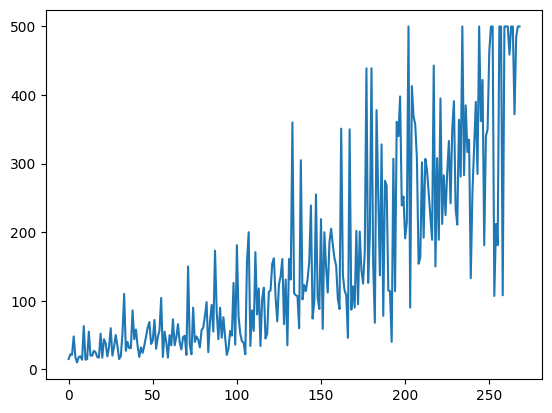

In [57]:
# <DO NOT CHANGE>
plt.plot(cat_vanilla_reinforce_total_rewards);
# </DO NOT CHANGE>

## 2.2 REINFORCE with Baseline

The vanilla REINFORCE algorithm has high variance because it relies solely on the sampled trajectories to estimate the gradient of the policy.
Since the return value from each trajectory depends on the stochasticity of the environment and the policy, the sampled returns can be pretty diverse, leading to noisy gradient estimates.

Introducing a baseline helps to reduce the variance of these gradient estimates.
The idea is to subtract a baseline value from the returns, which effectively centers the returns around zero.
Common choices for the baselines are the average return values or a value function approximating the expected return for each state.

When using a baseline, the update rule for the policy parameters becomes:

$$\theta \gets \theta + \alpha \times \sum_t \nabla_\theta (G_t - b(s_t)) \log \pi_\theta (a_t|s_t)$$

The term $(G_t - b(s_t))$ is called the advantage, representing how much better the sampled return is compared to the baseline.

Using a baseline reduces the variance because it centers the advantage values around zero, making the gradient updates less influenced by the inherent noise in the sampled returns.
Suppose the baseline is a good approximation of the expected return. In that case, the advantage values will be close to zero for actions that perform as expected and larger or smaller for actions that perform better or worse, respectively.
This leads to more stable and efficient learning in the REINFORCE algorithm.

🛑 <mark>TODO:</mark>
Implement REINFORCE with baseline algorithm. In this case, use the average of return values as the baseline
(i.e., $b(s_t) = \sum_{i=1}^{T} G_i / T$).

In [58]:
class REINFORCE_baseline(REINFORCE):
  def calculate_loss(self) -> torch.Tensor:
    DISCOUNT_FACTOR = 0.99  # Feel free to change this hyperparameter.

    # <TODO>
    # Calculate return values first, and then calculate loss.

    # First, you need to calculate the return values for each time step.

    # Second, calculate the advantage values.

    # Calculate the loss based on the advantage values above.
    returns_tensor = []
    returns = 0
    for reward in reversed(self.rewards):
      returns = returns * DISCOUNT_FACTOR
      returns = returns + reward
      returns_tensor.insert(0, returns)

    return_sum = []
    sum = 0
    i = 0
    for returns in reversed(returns_tensor):
      sum = sum + returns
      i = i + 1
      return_sum.insert(0, returns/i)

    #baseline = np.mean(returns_tensor)
    returns_tensor = torch.tensor(returns_tensor, dtype = torch.float32)

    loss = 0
    for l_prob, cur_return, baseline in zip(self.log_probs, returns_tensor, return_sum):
      loss = loss - (cur_return - baseline) * l_prob



    # </TODO>
    return loss

Let's run the training! Feel free to change the learning rate.

In [59]:
lr = 1e-3

# <DO NOT CHANGE>
reset_seed()
policy = SoftmaxPolicy(env.observation_space.shape[0], env.action_space.n)
agent = REINFORCE_baseline(policy, lr, solve_criteria=450, episode_limit=800)

cat_baseline_reinforce_total_rewards = agent.train(env)
# </DO NOT CHANGE>

reward avg: 456.10 min: 10.00 max: 500.00:  30%|███       | 243/800 [00:52<01:59,  4.64it/s]


SOLVED in 244 episodes!


Let's see the training result! You may see the baseline version solves faster compared to the vanilla version.

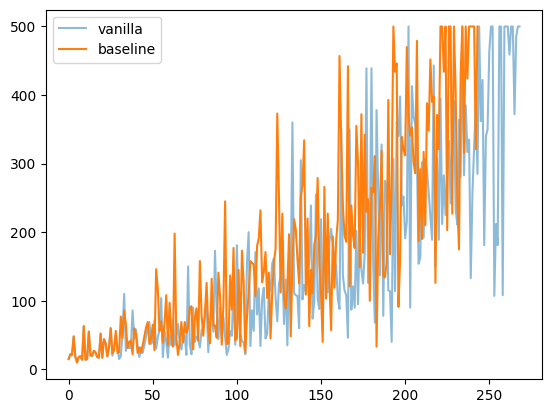

In [60]:
# <DO NOT CHANGE>
plt.plot(cat_vanilla_reinforce_total_rewards, label="vanilla", alpha=0.5);
plt.plot(cat_baseline_reinforce_total_rewards, label="baseline");
plt.legend(loc="upper left");
# </DO NOT CHANGE>

# 3. Actor-Critic

As mentioned above, we can use the value function $v(s)$ as a baseline of REINFORCE algorithm.
However, we cannot use it directly because we do not know the value, $v(s)$.

We can make a value function with a neural network just as we approximated a policy with a neural network.
In other words, we now have two types of neural networks: policy and value networks.
The policy network $\pi_\theta (a|s)$ is called the *actor*, because it tells us what to do. The other network, the value network, is called the *critic*, because it tells us how good our actions were. This architecture is called Actor-Critic.

## 3.1 Advantage Actor-Critic (A2C)

Advanced Actor-Critic (A2C) is a reinforcement learning algorithm that combines the Actor-Critic architecture with an advantage function, representing the relative benefit of a particular action compared to the average action in a given state. Now we have a value function $v_{\theta_v}(s_t)$, the advantage of an action $a_t$ can be defined as:

$$\mathrm{adv}_{\theta_v}(s_t) \doteq \bigl[ R_{t+1} + \gamma v_{\theta_v}(s_{t+1}) \bigr] - v_{\theta_v} (s_t)$$

The update rule of A2C is as follows:

$$\theta_\pi \gets \theta_\pi + \alpha \space \nabla_{\theta_\pi} \Bigl[ \mathrm{adv}_{\theta_v}(s_t) \log \pi_{\theta_\pi}(a_t|s_t) \Bigr]$$

$$\theta_v \gets \theta_v - \alpha \ \nabla_{\theta_v} \Bigl[ v_{\theta_v}(s_t) - \bigl(R_{t+1} + \gamma v_{\theta_v} (s_{t+1})\bigr)\Bigr]^2$$

We do not need to wait until the episode finishes because the update rule above has no return value $G_t$.

### 3.1.1 A2C training steps

The algorithm can be summarized in the following steps:

1. Initialize network parameters $\theta$ randomly.
2. Interaction with the environment and training the agent.
  1. Generate an action $a_t$ from the agent at the state $s_t$.
  2. Get $s_{t+1}$ and $R_{t+1}$ from the environment.
  3. Update the agent parameters $\theta_\pi$ and $\theta_v$.
3. Repeat step 2 until convergence or a stopping criterion is met.

🛑 <mark>TODO:</mark>
Implement A2C training steps.

In [61]:
class A2C:
  # <DO NOT CHANGE>
  def __init__(self, actor_model: nn.Module, critic_model: nn.Module, actor_lr: float, critic_lr: float, solve_criteria: float, episode_limit: int):
    self.actor_model = actor_model
    self.critic_model = critic_model
    self.actor_optimizer = optim.Adam(self.actor_model.parameters(), lr=actor_lr)
    self.critic_optimizer = optim.Adam(self.critic_model.parameters(), lr=critic_lr)
    self.solve_criteria = solve_criteria
    self.episode_limit = episode_limit
  # </DO NOT CHANGE>

  def calculate_loss(self, state, log_prob, reward, next_state, done) -> Tuple[torch.Tensor, torch.Tensor]:
    DISCOUNT_FACTOR = 0.99  # Feel free to change this hyperparameter.

    # <TODO>
    # This method should return [actor_loss, critic_loss]

    current_value = self.critic_model(state)
    if(done):
      next_value = torch.tensor(0.0, dtype=torch.float32)
    else:
      next_value = self.critic_model(next_state)
    adv = reward + DISCOUNT_FACTOR*next_value - current_value

    # calculate the actor loss
    actor_loss = -1 * log_prob * adv.detach()
    # calculate the critic loss
    critic_loss = adv**2

    # </TODO>
    return actor_loss, critic_loss

  def optimize(self, state, log_prob, reward, new_state, done):
    actor_loss, critic_loss = self.calculate_loss(state, log_prob, reward, new_state, done)

    # <TODO>
    # Update the actor and critic networks with the losses above.
    self.actor_optimizer.zero_grad()

    actor_loss.backward(retain_graph=True )

    self.actor_optimizer.step()

    self.critic_optimizer.zero_grad()

    critic_loss.backward(retain_graph=True )

    self.critic_optimizer.step()

    # </TODO>

  # <DO NOT CHANGE>
  def interaction_step(self, state, env):
    action, log_prob = self.actor_model.full_pass(state)
    new_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    reward = float(reward)

    self.rewards.append(reward)

    return log_prob, reward, new_state, done
  # </DO NOT CHANGE>

  def train(self, env):
    # <DO NOT CHANGE>
    total_rewards = []
    pbar = tqdm(range(1, self.episode_limit + 1))
    solved = False
    for episode in pbar:
      (state, _), done = env.reset(seed=SEED), False

      self.rewards = []
      # </DO NOT CHANGE>

      # <TODO>
      # Interact with the environment and update the model
      while not done:
        state = torch.tensor(state, dtype = torch.float32)
        log_prob, reward, new_state, done = self.interaction_step(state, env)
        self.optimize(state, log_prob, reward, new_state, done)
        state = new_state

      # </TODO>

      # <DO NOT CHANGE>
      total_reward = sum(self.rewards)
      total_rewards.append(total_reward)

      avg_rewards = np.mean(total_rewards[-10:])
      pbar.set_description(f"reward avg: {avg_rewards:.2f} min: {min(total_rewards):.2f} max: {max(total_rewards):.2f}")
      if avg_rewards >= self.solve_criteria:
        print(f"\nSOLVED in {episode} episodes!")
        solved = True
        break

    if not solved:
      raise Exception("Not solved. Please check your implementation!")

    return total_rewards
    # </DO NOT CHANGE>

### 2.1.2 Critic Network

The role of the critic network is to estimate the value. Therefore, the output of the critic network is scalar (i.e., $v_{\theta_v}(s) \in \mathbb{R}$).

🛑 <mark>TODO:</mark>
Implement the critic network.

In [62]:
class Critic(nn.Module):
  def __init__(self, in_features: int):
    # in_features: the size of state representation
    super(Critic, self).__init__()

    # <TODO>
    # Design your own neural network for Critic Network
    # Small networks are enough to solve CartPole. Use at most five linear layers.
    self.network = nn.Sequential(
        nn.Linear(in_features, 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    )

    # </TODO>

  def forward(self, x) -> torch.Tensor:
    if not isinstance(x, torch.Tensor):
      x = torch.tensor(x, dtype=torch.float32)
      x = x.unsqueeze(0)

    # <TODO>
    # Implement forward path of the neural network
    return self.network(x)

    # </TODO>

Let's run the training! Feel free to change the learning rates.

In [63]:
actor_lr = 1e-3
critic_lr = 1e-3

# <DO NOT CHANGE>
reset_seed()
policy = SoftmaxPolicy(env.observation_space.shape[0], env.action_space.n)
critic = Critic(env.observation_space.shape[0])
agent = A2C(policy, critic, actor_lr, critic_lr, solve_criteria=450, episode_limit=800)

cat_a2c_total_rewards = agent.train(env)
# </DO NOT CHANGE>

reward avg: 472.00 min: 12.00 max: 500.00:  41%|████▏     | 331/800 [02:19<03:17,  2.38it/s]


SOLVED in 332 episodes!


Let's see the training result!

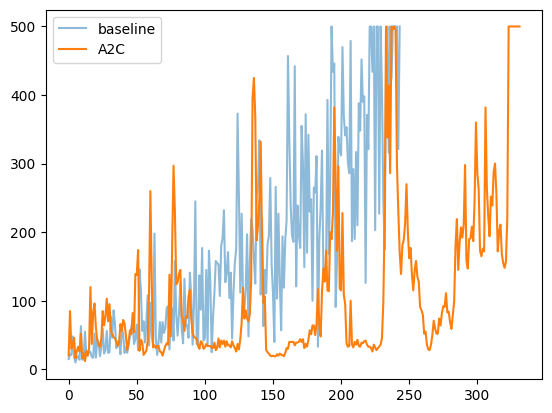

In [64]:
# <DO NOT CHANGE>
plt.plot(cat_baseline_reinforce_total_rewards, label="baseline", alpha=0.5);
plt.plot(cat_a2c_total_rewards, label="A2C");
plt.legend(loc="upper left");
# </DO NOT CHANGE>

# 4. DDPG

**Deep Deterministic Policy Gradient (DDPG)** is an Actor-Critic, model-free algorithm based on the deterministic policy gradient that can operate over continuous action space.
DDPG adapts the ideas underlying the success of Deep Q-Learning to the continuous action domain (DQN is unsuitable for continuous action spaces).

We have only dealt with discrete action spaces so far. Now move on to the continuous action space. DDPG can operate over continuous action spaces. Hence, let's implement DDPG algorithm with Pendulum environment that has a continuous action space.

In [65]:
env = gym.make("Pendulum-v1")

## 4.1 Actor-Critic Architecture in DDPG

**Deep Deterministic Policy Gradient (DDPG)** is a kind of Actor-Critic algorithm with a deterministic policy. Recall the implementation of the `SoftmaxPolicy`, where the `sample` method was called. In other words, the Softmax policy we implemented is stochastic.
In this case, we can describe an action as $a_t \sim \pi_\theta(a|s)$.

Now, let's discuss how to make a deterministic policy. The solution is quite simple. With a parameterized deterministic policy, the output of the actor-network is the action (i.e., $a_t = \pi_\theta(s_t)$).
In the case of stochastic policy, sampling is exploration itself. However, in the case of deterministic policy, we need an exploration method such as epsilon-greedy.

🛑 <mark>TODO:</mark>
Implement the actor-network for DDPG.

In [66]:
class DDPGActor(nn.Module):
  def __init__(self, in_features: int, out_features: int, action_range: float):
    # in_features: the size of state representation
    # out_features: the size of action representation
    # action_range: e.g., action \in [-2, 2] if action_range is 2.0
    super(DDPGActor, self).__init__()

    self.action_range = action_range

    # <TODO>
    # Design your own neural network for DDPGActor
    # Small networks are enough to solve Pendulum. Use at most five linear layers.
    # (Hint. the last layer should be nn.Tanh, because actions of Pendulum are in [-2, 2])
    self.network = nn.Sequential(
        nn.Linear(in_features, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, out_features),
        nn.Tanh()
    )

    # </TODO>

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    if not isinstance(x, torch.Tensor):
      x = torch.tensor(x, dtype=torch.float32)
      x = x.squeeze(-1).unsqueeze(0)

    # <TODO>
    # Implement forward path of the neural network

    return ((self.network(x)) * self.action_range).squeeze(0)

    # </TODO>

Unlike A2C, DDPG's critic network requires both state and action. Let's see the difference.

- In A2C: $v(s_t) = \mathrm{Critic}_{\theta_v}(s_t)$
- In DDPG: $v(s_t) = \mathrm{Critic}_{\theta_v}(s_t, a_t)$

The most common way for a neural network to take in two values at once is to concatenate them. (Hint. use `torch.cat` function)

🛑 <mark>TODO:</mark>
Implement the critic network for DDPG.

In [67]:
class DDPGCritic(nn.Module):
  def __init__(self, in_features_obs, in_features_act):
    # in_features_obs: the size of state representation
    # in_features_act: the size of action representation
    super(DDPGCritic, self).__init__()

    # <TODO>
    # Design your own neural network for DDPGCritic
    # Small networks are enough to solve Pendulum. Use at most five linear layers.
    ##self.action_net = nn.Linear(in_features_act, 1)
    #self.state_net = nn.Linear(in_features_obs, 1)
    self.network = nn.Sequential(
        nn.Linear(in_features_act + in_features_obs, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 1)
    )

    # </TODO>

  def forward(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
    if not isinstance(state, torch.Tensor):
      state = torch.tensor(state, dtype=torch.float32)
      state = state.squeeze(-1).unsqueeze(0)

    if not isinstance(action, torch.Tensor):
      action = torch.tensor(action, dtype=torch.float32)
      action = action.unsqueeze(0)

    # <TODO>
    # Implement forward path of the neural network

    x = torch.cat((state, action), dim=1)
    return self.network(x)
    #squeeze(-1)
    # </TODO>

## 4.2 Replay Buffer

Replay Buffer stores past experiences and enables the algorithm to sample and learn from these experiences more efficiently and stably, breaking the correlation between consecutive samples and mitigating the issue of non-stationarity caused by the constantly updating policy and value function approximators.

To train Actor-Critic architecture, transition data ($s_t$, $a_t$, $R_{t+1}$, $s_{t+1}$, $\delta_{t+1}$) is required, where $\delta_{t+1}$ is `done` in the code below. Hence, the replay buffer should store transitions. The replay buffer should provide an operation: sample mini-batch from the buffer.

🛑 <mark>TODO:</mark>
Implement the replay buffer.

In [68]:
class ReplayBuffer:
  def __init__(self, capacity: int):
    self.capacity = capacity
    self.buffer = []

  def push(self, transition):
    # <TODO>
    (self.buffer).append(transition)
    if len(self.buffer) > self.capacity:
      self.buffer.pop(0)

    # </TODO>

  def sample(self, batch_size: int):
    # <TODO>
    if len(self.buffer) >= batch_size:
      return random.sample(self.buffer, batch_size)

    # </TODO>

  def __len__(self):
    return len(self.buffer)

## 4.3 DDPG algorithm

🛑 <mark>TODO:</mark>
Please refer to the pseudo-code below to implement the DDPG algorithm.

![alt text](https://i.imgur.com/mS6iGyJ.jpg)

In [69]:
class DDPG:
  def __init__(self, buffer: ReplayBuffer, actor: DDPGActor, critic: DDPGCritic, actor_lr: float, critic_lr: float, solve_criteria: float, episode_limit: int):
    # <DO NOT CHANGE>
    self.buffer = buffer

    self.actor = actor
    self.critic = critic
    self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
    self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)

    self.target_actor = deepcopy(self.actor)
    self.target_critic = deepcopy(self.critic)

    self.solve_criteria = solve_criteria
    self.episode_limit = episode_limit
    # </DO NOT CHANGE>

  @staticmethod
  def soft_target_update(net: nn.Module, target_net: nn.Module, tau: float):
    # <DO NOT CHANGE>
    for param, target_param in zip(net.parameters(), target_net.parameters()):
      target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
    # </DO NOT CHANGE>

  def update(self):
    # Feel free to change these hyperparameters.
    BATCH_SIZE = 32
    DISCOUNT_FACTOR = 0.99
    TAU = 0.005

    # <TODO>

    # Sample replay buffer and calculate critic loss.

    trans_sample = self.buffer.sample(BATCH_SIZE)
    if len(self.buffer) < BATCH_SIZE:
      return

    cur_state = []
    act = []
    reward = []
    next_state = []
    done = []
    for tran in trans_sample:
      cur_state.append(tran[0])
      act.append(tran[1])
      reward.append(tran[2])
      next_state.append(tran[3])
      done.append(tran[4])

    cur_state = torch.tensor(np.array(cur_state), dtype = torch.float32)
    act = torch.tensor(np.array(act), dtype = torch.float32)
    reward = torch.tensor(np.array(reward), dtype = torch.float32)
    next_state = torch.tensor(np.array(next_state), dtype = torch.float32)
    done = torch.tensor(np.array(done), dtype = torch.float32)

    reward = reward.unsqueeze(-1)
    done = done.unsqueeze(-1)

    with torch.no_grad():
      target_actions = self.target_actor(next_state)
      target_q_values = self.target_critic(next_state, target_actions).detach()
      y = reward + DISCOUNT_FACTOR * target_q_values * (1 - done)

    cur_q_val = self.critic(cur_state, act)
    critic_loss = torch.nn.functional.mse_loss(cur_q_val, y)

    # With loss above, update the critic network.

    self.critic_optimizer.zero_grad()

    critic_loss.backward()

    self.critic_optimizer.step()

    # Calculate actor loss and update the actor network.

    actor_action = self.actor(cur_state)
    actor_loss = -self.critic(cur_state, actor_action).mean()

    self.actor_optimizer.zero_grad()

    actor_loss.backward()

    self.actor_optimizer.step()

    # Update the target networks
    self.soft_target_update(self.critic, self.target_critic, TAU)
    self.soft_target_update(self.actor, self.target_actor, TAU)


    # </TODO>

  def interaction_step(self, state, env):
    action = self.actor(state)
    action = action.detach().numpy().flatten()

    # <TODO>
    # Policy is deterministic, therefore we need to add a noise to action for exploration.
    # A noise can be sampled from a Gaussian distribution. (Hint. np.random.normal)
    noise_scale = 0.1
    noise = np.random.normal(0, noise_scale, size=action.shape)
    action = action + noise
    min = -env.action_space.high
    max = env.action_space.high
    action = np.clip(action, min, max)

    # </TODO>
    new_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    reward = float(reward)

    return action, reward, new_state, done

  def train(self, env):
    # <DO NOT CHANGE>
    total_rewards = []
    pbar = tqdm(range(1, self.episode_limit + 1))
    solved = False
    for episode in pbar:
      (state, _), done = env.reset(seed=SEED), False

      self.rewards = []
    # </DO NOT CHANGE>

      # <TODO>
      # Interact with the environment and update the model
      # You need to update the replay buffer also!!
      while not done:
        state = torch.tensor(state, dtype = torch.float32)
        action, reward, new_state, done = self.interaction_step(state, env)
        transition = (state, action, reward, new_state, bool(done))
        self.rewards.append(reward)
        self.buffer.push(transition)
        self.update()
        state = new_state

      # </TODO>

    # <DO NOT CHANGE>
      total_reward = sum(self.rewards)
      total_rewards.append(total_reward)

      avg_rewards = np.mean(total_rewards[-10:])
      pbar.set_description(f"reward avg: {avg_rewards:.2f} min: {min(total_rewards):.2f} max: {max(total_rewards):.2f}")
      if avg_rewards >= self.solve_criteria:
        print(f"\nSOLVED in {episode} episodes!")
        solved = True
        break

    if not solved:
      raise Exception("Not solved. Please check your implementation!")

    return total_rewards
    # </DO NOT CHANGE>

Let's run the training! Feel free to change the learning rates.

In [70]:
actor_lr = 1e-4
critic_lr = 1e-3

# <DO NOT CHANGE>
reset_seed()
buffer = ReplayBuffer(10000)
actor = DDPGActor(env.observation_space.shape[0], env.action_space.shape[0], 2)
critic = DDPGCritic(env.observation_space.shape[0], env.action_space.shape[0])
agent = DDPG(buffer, actor, critic, actor_lr, critic_lr, solve_criteria=-200, episode_limit=300)

ddpg_total_rewards = agent.train(env)
# </DO NOT CHANGE>

reward avg: -187.73 min: -1675.82 max: -120.85:  31%|███       | 92/300 [02:18<05:12,  1.50s/it]


SOLVED in 93 episodes!


Let's see the result!

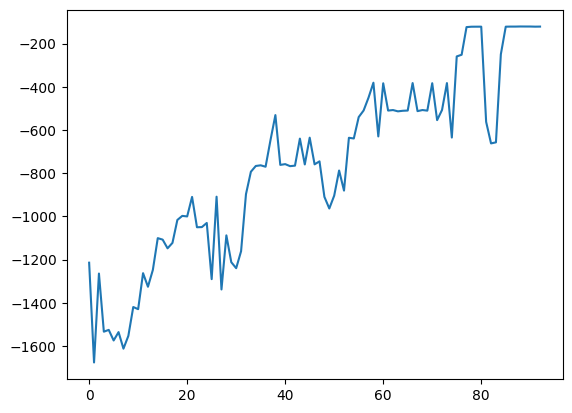

In [71]:
# <DO NOT CHANGE>
plt.plot(ddpg_total_rewards);
# </DO NOT CHANGE>